In [1]:
import numpy as np
import pandas as pd
import math
import cPickle as pickle

In [2]:
file = '/Users/JH/Desktop/NTU/NTU_Research/data/NEM_Load_Forecasting_Database.xls'

QLD = 'Actual_Data_QLD'
NSW = 'Actual_Data_NSW'
VIC = 'Actual_Data_VIC'
SA = 'Actual_Data_SA'
TAS = 'Actual_Data_TAS'

In [3]:
# Set Classes as Data Container

class Structure:
    def __init__(self):
        self._feature = []
        self._target = []

    @property
    def feature(self):
        return self._feature

    @property
    def target(self):
        return self._target

    @feature.setter
    def feature(self, value):
        self._feature = value

    @target.setter
    def target(self, value):
        self._target = value


class Data:
    def __init__(self):
        pass

    class Train(Structure):
        def __init__(self):
            pass

    class Test(Structure):
        def __init__(self):
            pass


class DataSet:
    def __init__(self):
        pass

    class Raw:
        def __init__(self):
            pass

        class Train(Structure):
            def __init__(self):
                pass

        class Test(Structure):
            def __init__(self):
                pass

    class PreProcessed:
        def __init__(self):
            pass

        class Train(Structure):
            def __init__(self):
                pass

        class Test(Structure):
            def __init__(self):
                pass

In [4]:
# Set Functions

def normalization(data):
    return (data - min(data)) / (max(data) - min(data))


def data_splitter(data, ratio=0.8):
    """
    split data into training data & testing data
    :param data:

    :param ratio:
        training data ratio
    :return:
        train_data, test_data
    """
    splitter = int(len(data) * ratio)
    return np.array(data[:splitter]), np.array(data[splitter + 1:])


def preprocessing_filter(data, nominator, denominator):
    return normalization(data) ** (nominator / denominator)


def preprocessing(data_present, temperature_max, temperature_mean, denominator):
    data_present = list(data_present) + list(
        preprocessing_filter(np.array(data_present), temperature_max, denominator)) + list(
        preprocessing_filter(np.array(data_present), temperature_mean, denominator))

    return np.array(data_present)


def data_alloter(df):
    dataset = DataSet()
    denominator = df['Mean Tem.'].min()

    raw_feature = []
    raw_target = []
    preprocessed_feature = []
    preprocessed_target = []

    for row in range(0, len(df)):
        # if both MaxTemp and MeanTemp are not nan
        if not math.isnan(df['Max Tem.'][row]) and not math.isnan(df['Mean Tem.'][row]):
            if not math.isnan(df['Max Tem.'][row + 1]) and not math.isnan(df['Mean Tem.'][row + 1]):
                # Raw
                powerload_present = np.array(df.loc[row][5:53])
                powerload_future = np.array(df.loc[row + 1][5:53])

                raw_feature.append(np.array(
                    list(powerload_present) + list([df['Max Tem.'][row + 1]]) + list([df['Mean Tem.'][row + 1]])))
                raw_target.append(np.array(powerload_future))
                
                #Preprocessed
                powerload_present = normalization(np.array(df.loc[row][5:53]))
                powerload_future = normalization(np.array(df.loc[row + 1][5:53]))
                
                preprocessed_powerload_present = preprocessing(powerload_present,
                                                               df['Max Tem.'][row + 1],
                                                               df['Mean Tem.'][row + 1],
                                                               denominator)

                preprocessed_feature.append(preprocessed_powerload_present)
                preprocessed_target.append(np.array(powerload_future))
    
    # Raw
    dataset.Raw.Train.feature, dataset.Raw.Test.feature = data_splitter(raw_feature)
    dataset.Raw.Train.target, dataset.Raw.Test.target = data_splitter(raw_target)
    
    #Preprocessed
    dataset.PreProcessed.Train.feature, dataset.PreProcessed.Test.feature = data_splitter(preprocessed_feature)
    dataset.PreProcessed.Train.target, dataset.PreProcessed.Test.target = data_splitter(preprocessed_target)

    return dataset

In [5]:
df = pd.read_excel(file, sheetname=QLD)
data_set = data_alloter(df)

In [6]:
import tensorflow as tf

In [7]:
# Parameters
num_steps = 20000
data_showing_step = 100
batch_size = 30

# Network Parameters
n_hidden_1 = 150  # 1st layer number of features
n_hidden_2 = 100  # 2nd layer number of features
n_hidden_3 = 100  #
n_hidden_4 = 50  #
n_input = 144
n_classes = 48

In [8]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
learning_rate_decayed = tf.placeholder(tf.float32, shape=[])


# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    # Hidden layer with RELU activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    return out_layer


# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'out': tf.Variable(tf.random_normal([n_hidden_4, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y - pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate_decayed).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [9]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)

# Training cycle
for step in range(num_steps):

    # learning_rate_decayed
    if step < 3000:
        learning_rate = 0.001
    elif 3000 <= step < 6000:
        learning_rate = 0.00005
    else:
        learning_rate = 0.00000001

    avg_cost = 0.
    total_batch = int(data_set.PreProcessed.Train.feature.shape[0] / batch_size)

    # set a offset
    offset = (step * batch_size) % (data_set.PreProcessed.Train.target.shape[0] - batch_size)
    # Generate a minibatch.
    batch_x = data_set.PreProcessed.Train.feature[offset:(offset + batch_size), :]
    batch_y = data_set.PreProcessed.Train.target[offset:(offset + batch_size), :]

    # Run optimization op (backprop)
    _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y, learning_rate_decayed: learning_rate})
    # Compute average loss
    avg_cost += c / total_batch

    if (step % data_showing_step == 0):
        print "step:", '%04d' % (step), "cost=", "{:.9f}".format(avg_cost)

print "Optimization Finished!"

step: 0000 cost= 13299524.363636363
step: 0100 cost= 6004.876420455
step: 0200 cost= 0.190194780
step: 0300 cost= 0.152191780
step: 0400 cost= 0.153560649
step: 0500 cost= 0.136478652
step: 0600 cost= 0.099080162
step: 0700 cost= 0.104225755
step: 0800 cost= 0.089862005
step: 0900 cost= 0.064705572
step: 1000 cost= 0.067577237
step: 1100 cost= 0.057480330
step: 1200 cost= 0.041827806
step: 1300 cost= 0.041820296
step: 1400 cost= 0.035429358
step: 1500 cost= 0.026580480
step: 1600 cost= 0.023912544
step: 1700 cost= 0.020919462
step: 1800 cost= 0.015381618
step: 1900 cost= 0.012569154
step: 2000 cost= 0.011479767
step: 2100 cost= 0.008381699
step: 2200 cost= 0.005730382
step: 2300 cost= 0.005784629
step: 2400 cost= 0.003842618
step: 2500 cost= 0.002211197
step: 2600 cost= 0.002402529
step: 2700 cost= 0.001606175
step: 2800 cost= 0.001065948
step: 2900 cost= 0.001005151
step: 3000 cost= 0.000864774
step: 3100 cost= 0.001912864
step: 3200 cost= 0.000821468
step: 3300 cost= 0.000845897
step

In [14]:
batch_x = data_set.PreProcessed.Test.feature
batch_y = data_set.PreProcessed.Test.target
pred_test, cost_test =  sess.run([pred, cost], feed_dict={x: batch_x, y: batch_y})

In [15]:
print cost_test

60.7318


In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

<IPython.core.display.Javascript object>


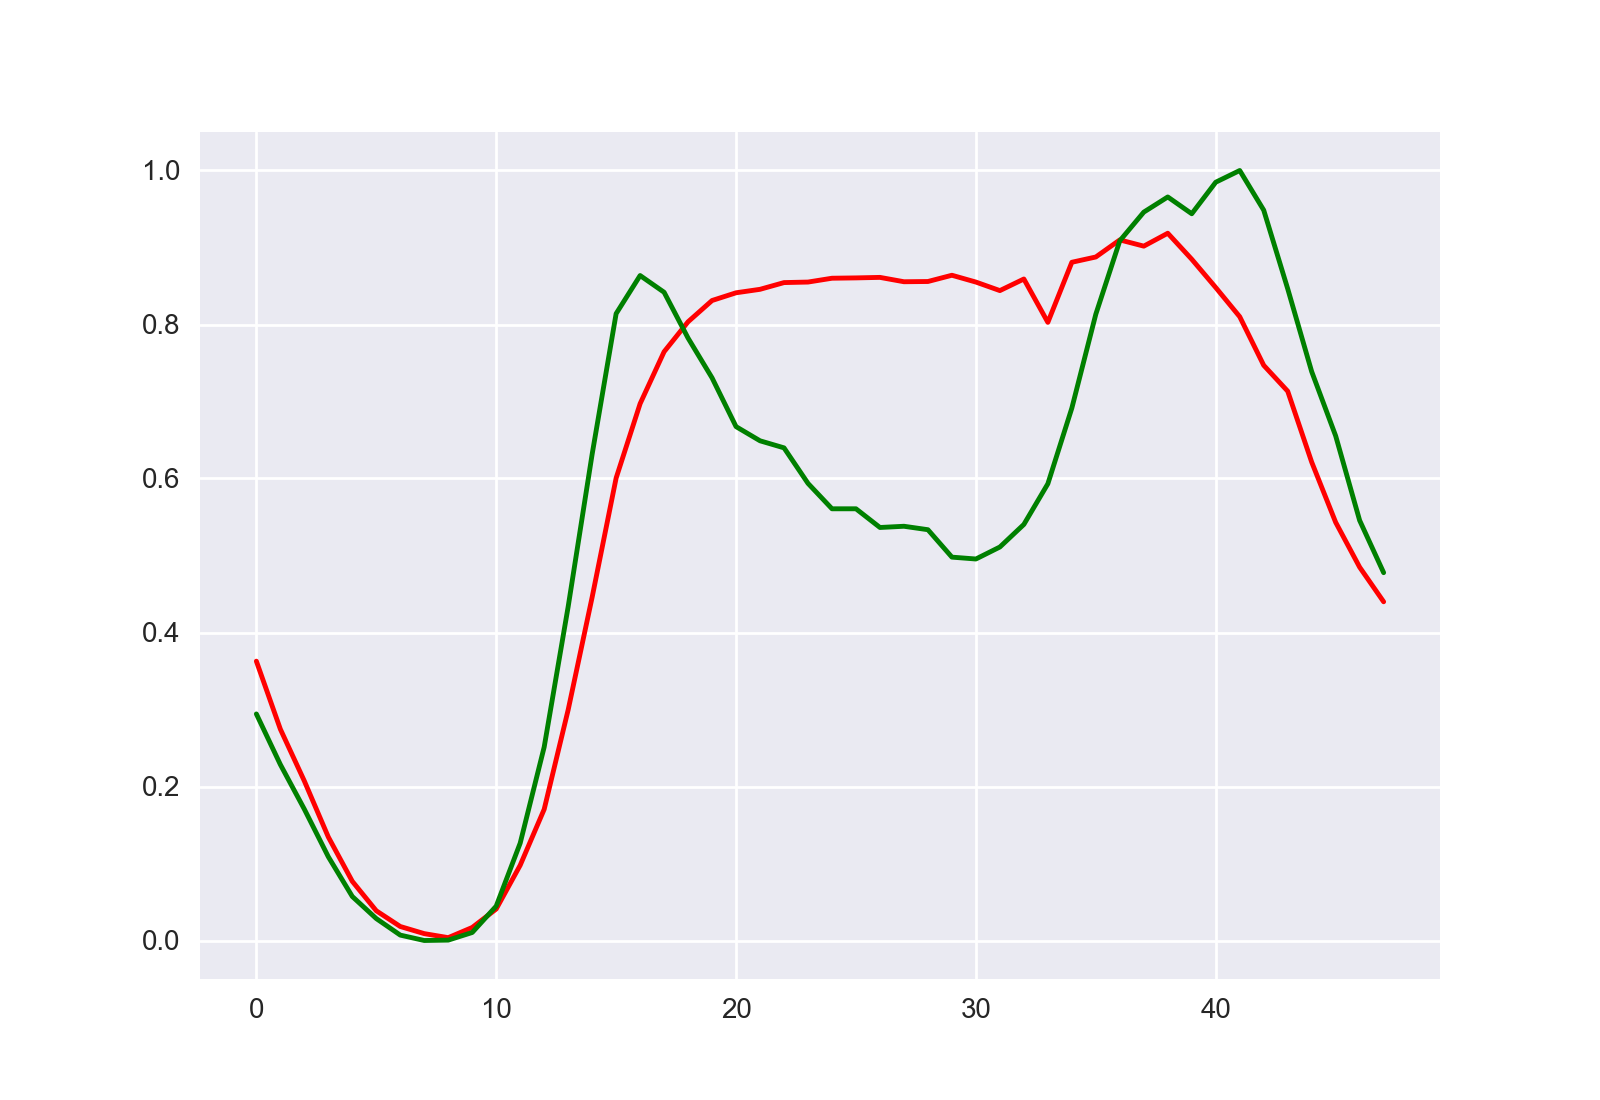

In [21]:
time = np.arange(0, 48, 1)
plt.plot(time, pred_test[3], 'r', 
         time, data_set.PreProcessed.Test.target[3], 'g')
plt.show()